<a href="https://colab.research.google.com/github/yelangsung/CIFAR-10-Dataset-Classification/blob/main/CIFAR-10_Classifcation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---


In [1]:
#set up

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html


In [ ]:
#data loader
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
# test set
transforms_cifar10_test = transforms.Compose([transforms.Resize((32, 32)),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])



# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:08<00:00, 20136306.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 frog   dog horse   cat


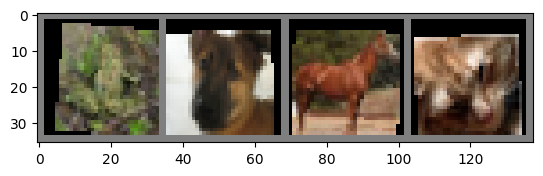

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **CNN**

Implement network using libraries.

In [ ]:
# VGG19 Model

cfg = {
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.features = self.make_layers(cfg['VGG19'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

net = VGG19().to(device)


# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.


In [ ]:
# Loss function and optimizer
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma=0.1)

# **Train the network**

Train network using the loss function and optimizer.

In [ ]:
path='/path/to/checkpoints/my_model_check.pt'

class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=15, verbose=False, delta=0,path=path):

        self.patience = patience #기다리는 시간, Default : 15
        self.verbose = verbose #True로 설정하면 각 개선 사항에 대한 메시지 출력, Default : False
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = np.Inf
        self.delta = delta #개선되었다고 인정되는 최소 변화량을 나타내는 변수, Default : 0
        self.path = path

       # Create the parent directory if it does not exist
        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def __call__(self, val_acc, model):

        score = val_acc

        if self.best_score is None:
            self.best_score = score #self.best_score 에 score 를 저장, 모델 저장
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.delta: #score가 self.best_score + self.delta 보다 작으면 self.counter 증가
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: #self.early_stop을 True 로 설정, 학습 조기 중지
                self.early_stop = True
        else: #score 가 self.best_score + self.delta 보다 크면
            self.best_score = score #self.best_score 업데이트, 모델 저장
            self.save_checkpoint(val_acc, model)
            self.counter = 0 #self.counter 0으로 초기화

    def save_checkpoint(self, val_acc, model):
        if self.verbose:
            print(f'Accuracy improve ({self.val_acc_max:.6f} --> {val_acc:.6f}).Saving model...')
        torch.save(model.state_dict(),self.path) # torch.save(model, self.path)
        self.val_acc_max = val_acc

In [ ]:
#Train the model
epochs = 30

#running_loss = loss_tmp
total = 0
learning_rate = 0.0001
weight_decay = 0.001

train_losses = []
valid_losses = []
avg_train_losses = []
avg_valid_losses = []
loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], [] #plot 위한 dictionary 정의

#early stop the network
early_stopping = EarlyStopping(patience = 15, verbose = True)

for epoch in range(epochs):
  net.train()

  correct1 = 0  # 모델이 정확하게 예측한 샘플의 수
  running_loss = 0.0 # 전체 epoch의 loss 총합.

  loss_tmp = 0.0
  epoch_loss = 0.0

  for i, data in enumerate(trainloader, start=0):

    # Load the data
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Estimate the output using the network
    outputs = net(inputs)
    # Calculate the loss between the output of the network and label
    loss = loss_fun(outputs, labels)

    # Optimize the network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_tmp += loss.data
    epoch_loss += loss.data
    running_loss += loss.item()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct1 += (predicted == labels).sum().item()

    if i % 5000 == 4999:    # Print loss every 5000 mini-batches
        print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
              (epoch + 1, i + 1, loss_tmp / (i+1)))
        loss_tmp = 0.0

  avg_loss = running_loss / len(trainset) # 전체 epoch의 loss 평균
  avg_acc = correct1 / len(trainset)  # 전체 epoch의 loss accuracy 평균.
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  net.eval() # added for 추론.
    # 한 번 epoch할 때마다 test. computation memory saving.
  with torch.no_grad():
    loss_val = 0.0
    correct2 = 0 #initialize
    for data in testloader:
      # Load the data
      inputs_test, labels_test = data
      inputs_test = inputs_test.to(device)
      labels_test = labels_test.to(device)

      # Estimate the output using the trained network
      outputs_test = net(inputs_test)
      loss = loss_fun(outputs_test, labels_test)
      _, predicted = torch.max(outputs_test.data, 1)
      loss_val += loss.item()
      valid_losses.append(loss.item())

      # Calculate the accuracy
      total += labels_test.size(0)
      correct2 += (predicted == labels_test).sum().item() # .item

    avg_loss_val = loss_val / len(testset)
    avg_acc_val = correct2 / len(testset)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)

  net.train()
  # Update the learning rate according to the learnig rate scheduler
  if scheduler:
    scheduler.step()

  print('[Epoch - %d] Loss: %.3f average loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' %(epoch + 1, epoch_loss / (i+1), avg_loss, avg_acc, avg_loss_val, avg_acc_val))

    # Print the epoch loss + early stop
  early_stopping(avg_acc_val, net)

  if early_stopping.early_stop:
      print("Early stopping")
      break

print('Finished Training')

[Epoch - 1, Iteration -  5000] Loss: 0.986
[Epoch - 1, Iteration - 10000] Loss: 0.463
[Epoch - 1] Loss: 0.944 average loss: 0.23595 accuracy: 0.6731 val loss: 0.18557 val accuracy: 0.7481
Accuracy improve (inf --> 0.748100).Saving model...
[Epoch - 2, Iteration -  5000] Loss: 0.837
[Epoch - 2, Iteration - 10000] Loss: 0.405
[Epoch - 2] Loss: 0.819 average loss: 0.20479 accuracy: 0.7198 val loss: 0.16291 val accuracy: 0.7752
Accuracy improve (0.748100 --> 0.775200).Saving model...
[Epoch - 3, Iteration -  5000] Loss: 0.745
[Epoch - 3, Iteration - 10000] Loss: 0.361
[Epoch - 3] Loss: 0.730 average loss: 0.18259 accuracy: 0.7508 val loss: 0.16835 val accuracy: 0.7722
EarlyStopping counter: 1 out of 15
[Epoch - 4, Iteration -  5000] Loss: 0.677
[Epoch - 4, Iteration - 10000] Loss: 0.326
[Epoch - 4] Loss: 0.665 average loss: 0.16615 accuracy: 0.7728 val loss: 0.14799 val accuracy: 0.8033
Accuracy improve (0.775200 --> 0.803300).Saving model...
[Epoch - 5, Iteration -  5000] Loss: 0.617


# **Test the network**

Test the trained network using the testset.


In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset

correct = 0
total = 0
net.load_state_dict(torch.load('/path/to/checkpoints/my_model_check.pt'))

with torch.no_grad():
  net.eval() ##we do not use dropout at test time!
  for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()


In [ ]:
# Visualizing

import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()